In [1]:
# -*- coding: UTF-8 -*- 
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
from numpy import NaN, Inf, arange, isscalar, asarray, array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import pickle
import cv2
import scipy.signal as signal
import heapq
from compiler.ast import flatten
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
caffe_root = '/LANE/caffe/'
deployPrototxt = '/LANE/caffe/models/vpgnet-novp/deploy.prototxt'
modelFile = '/LANE/caffe/models/vpgnet-novp/snapshots/official.caffemodel'
meanFile = 'models/vpgnet-novp/driving_mean_train.binaryproto'
sys.path.insert(0, caffe_root + 'python')
import caffe
colors = {1:'r', 2:'b', 3:'g', 4:'k', 5:'y', 6:'c', 7:'m', 8:'w'}

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.
  from ipykernel import kernelapp as app


In [2]:
def initilize():
    print 'initilize ... '
    gid = -1
    if gid != -1:
        caffe.set_mode_gpu()
        caffe.set_device(gid)
        print "Using GPU id", gid
    else:
        caffe.set_mode_cpu()
        print "Using CPU"
    net = caffe.Net(deployPrototxt, modelFile, caffe.TEST)
    return net

convert_mean
(3, 512, 672)
return npyMean


array([91.8595588 , 90.18846023, 82.76530798])

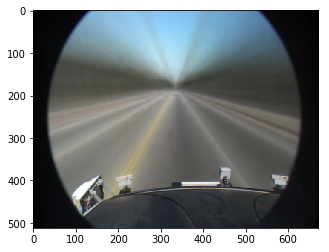

In [3]:
def convert_mean(binMean,npyMean):
    print('convert_mean')
    mean = caffe.proto.caffe_pb2.BlobProto.FromString(open(binMean).read())
    array = np.array(caffe.io.blobproto_to_array(mean))
    mn = array[0] 
    np.save(npyMean ,mn)
    print(mn.shape)
    mu = mn.mean(1).mean(1) 
    mn = mn.reshape(mean.channels, mean.height, mean.width)
    mn = mn.transpose((1,2,0))
    pmn = mn.copy()
    pmn = (pmn-pmn.min())/(pmn.max() - pmn.min())
    plt.imshow(pmn[:,:,[2,1,0]])
    print('return npyMean')
    return mu
binMean=caffe_root + meanFile
npyMean=caffe_root+'/models/vpgnet-novp/driving_mean_train.npy'
convert_mean(binMean,npyMean)

In [4]:
def preinfer(net):
    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    binMean=caffe_root + meanFile
    npyMean=caffe_root+'/models/vpgnet-novp/driving_mean_train.npy'
    npyMean = convert_mean(binMean,npyMean)
    #transformer.set_mean('data', np.load(npyMean).mean(1).mean(1)) # mean pixel
    transformer.set_mean('data', npyMean)
    transformer.set_raw_scale('data', 255)  
    # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  
    # the reference model has channels in BGR order instead of RGB
    print('return transformer')
    return transformer
#preinfer(initilize())

In [5]:
def get_img(image_path):
    print('to get image')
    image = caffe.io.load_image(image_path, False)
    image = caffe.io.resize(image, (640, 480))
    print('return image')
    return image

In [6]:
def inference(image_path, net):
    transformer = preinfer(net)
    image = get_img(image_path)
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    net.forward()
    print '# blob info of net...'
    print '\n'.join(str(k)+":"+str(v) for k,v in [(k, v.data.shape) for k, v in net.blobs.items()])
    print '# param info of net...'
    print '\n'.join(str(k)+":"+str(v) for k,v in [(k, v[0].data.shape) for k, v in net.params.items()])
    return net 
def extract_features(net,layer_name,channels,single_layer=0,factor=8):
    if not net.blobs.has_key(layer_name):
        print("layer's name is not exist.")
        return
    if channels < 1:
        fea = net.blobs[layer_name].data[0]
    elif single_layer == 0:        
        fea = net.blobs[layer_name].data[0][0:channels]
    else:
        fea = net.blobs[layer_name].data[0][channels-1:channels]
    multi_label_shifted = np.zeros(fea.shape)
    shift = 1
    if 'binary-mask' in layer_name:
        shift = 3
    multi_label_shifted[:,shift:,shift:] = fea[:,:-shift,:-shift]
    return vis_and_resize(multi_label_shifted,0,0,factor)

def vis_and_resize(data, padsize=1, padval=0, factor=8):
    data -= data.min()
    data /= data.max()
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = cv2.resize(data, (640, 480), fx=factor, fy=factor, interpolation=cv2.INTER_AREA)
    return data

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
    if x is None:
        x = arange(len(v))
    v = asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN    
    lookformax = True    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return array(maxtab), array(mintab)

def sampling_peaks(series):
    window = signal.general_gaussian(51, p=1, sig=5)
    filtered = signal.fftconvolve(window, series)
    filtered = (np.average(series) / np.average(filtered)) * filtered
    filtered = np.roll(filtered, -25)
    if len(filtered) > len(series):
        filtered = filtered[:len(series)]
    maxtab, mintab = peakdet(filtered,abs(min(filtered)))
    if len(array(maxtab)) is 0:
        return array([])
    return array(maxtab)[:,0]

def post_processing(mask, clo, th=90):
    if not colors.has_key(clo):
        print 'color key error!'
        return None  
    height, width = mask.shape[:2]
    x = []
    y = []
    min_val = min(flatten(mask.tolist()))
    for i in range(height):
        peaks = sampling_peaks(mask[i].tolist()).tolist()
        for item in peaks[:]:
            if abs(mask[i].tolist()[int(item)]-min_val)<=th:
                peaks.remove(item)
        y.extend([i]*len(peaks))
        x.extend(peaks)
    return x, y, clo

initilize ... 
Using CPU


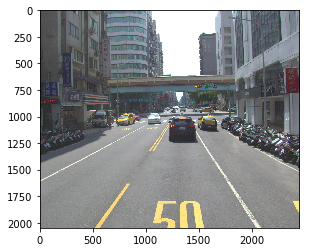

In [7]:
net = initilize()
testimage = 'test_img/1.jpg'
img = cv2.imread(testimage)
plt.imshow(img[:,:,[2,1,0]])

convert_mean
(3, 512, 672)
return npyMean
return transformer
to get image


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


return image
# blob info of net...
data:(1, 3, 480, 640)
L0:(1, 96, 118, 158)
norm1:(1, 96, 118, 158)
pool1:(1, 96, 59, 79)
L1:(1, 256, 59, 79)
norm2:(1, 256, 59, 79)
pool2:(1, 256, 29, 39)
L2:(1, 384, 29, 39)
L3:(1, 384, 29, 39)
L4:(1, 384, 29, 39)
pool5:(1, 384, 14, 19)
L5:(1, 4096, 15, 20)
L5_relu6_0_split_0:(1, 4096, 15, 20)
L5_relu6_0_split_1:(1, 4096, 15, 20)
L5_relu6_0_split_2:(1, 4096, 15, 20)
L6a:(1, 4096, 15, 20)
L6b:(1, 4096, 15, 20)
L6c:(1, 4096, 15, 20)
bb-output:(1, 256, 15, 20)
pixel-conv:(1, 128, 15, 20)
type-conv:(1, 1024, 15, 20)
pixel-conv-tiled:(1, 2, 120, 160)
bb-output-tiled:(1, 4, 120, 160)
type-conv-tiled:(1, 64, 60, 80)
binary-mask:(1, 2, 120, 160)
multi-label:(1, 64, 60, 80)
# param info of net...
L0:(96, 3, 11, 11)
L1:(256, 96, 5, 5)
L2:(384, 256, 3, 3)
L3:(384, 384, 3, 3)
L4:(384, 384, 3, 3)
L5:(4096, 384, 6, 6)
L6a:(4096, 4096, 1, 1)
L6b:(4096, 4096, 1, 1)
L6c:(4096, 4096, 1, 1)
bb-output:(256, 4096, 1, 1)
pixel-conv:(128, 4096, 1, 1)
type-conv:(1024, 4096,

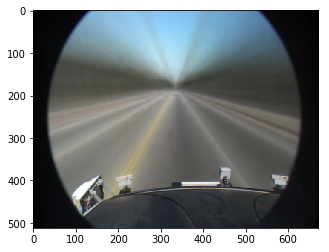

In [8]:
net = inference(testimage, net)

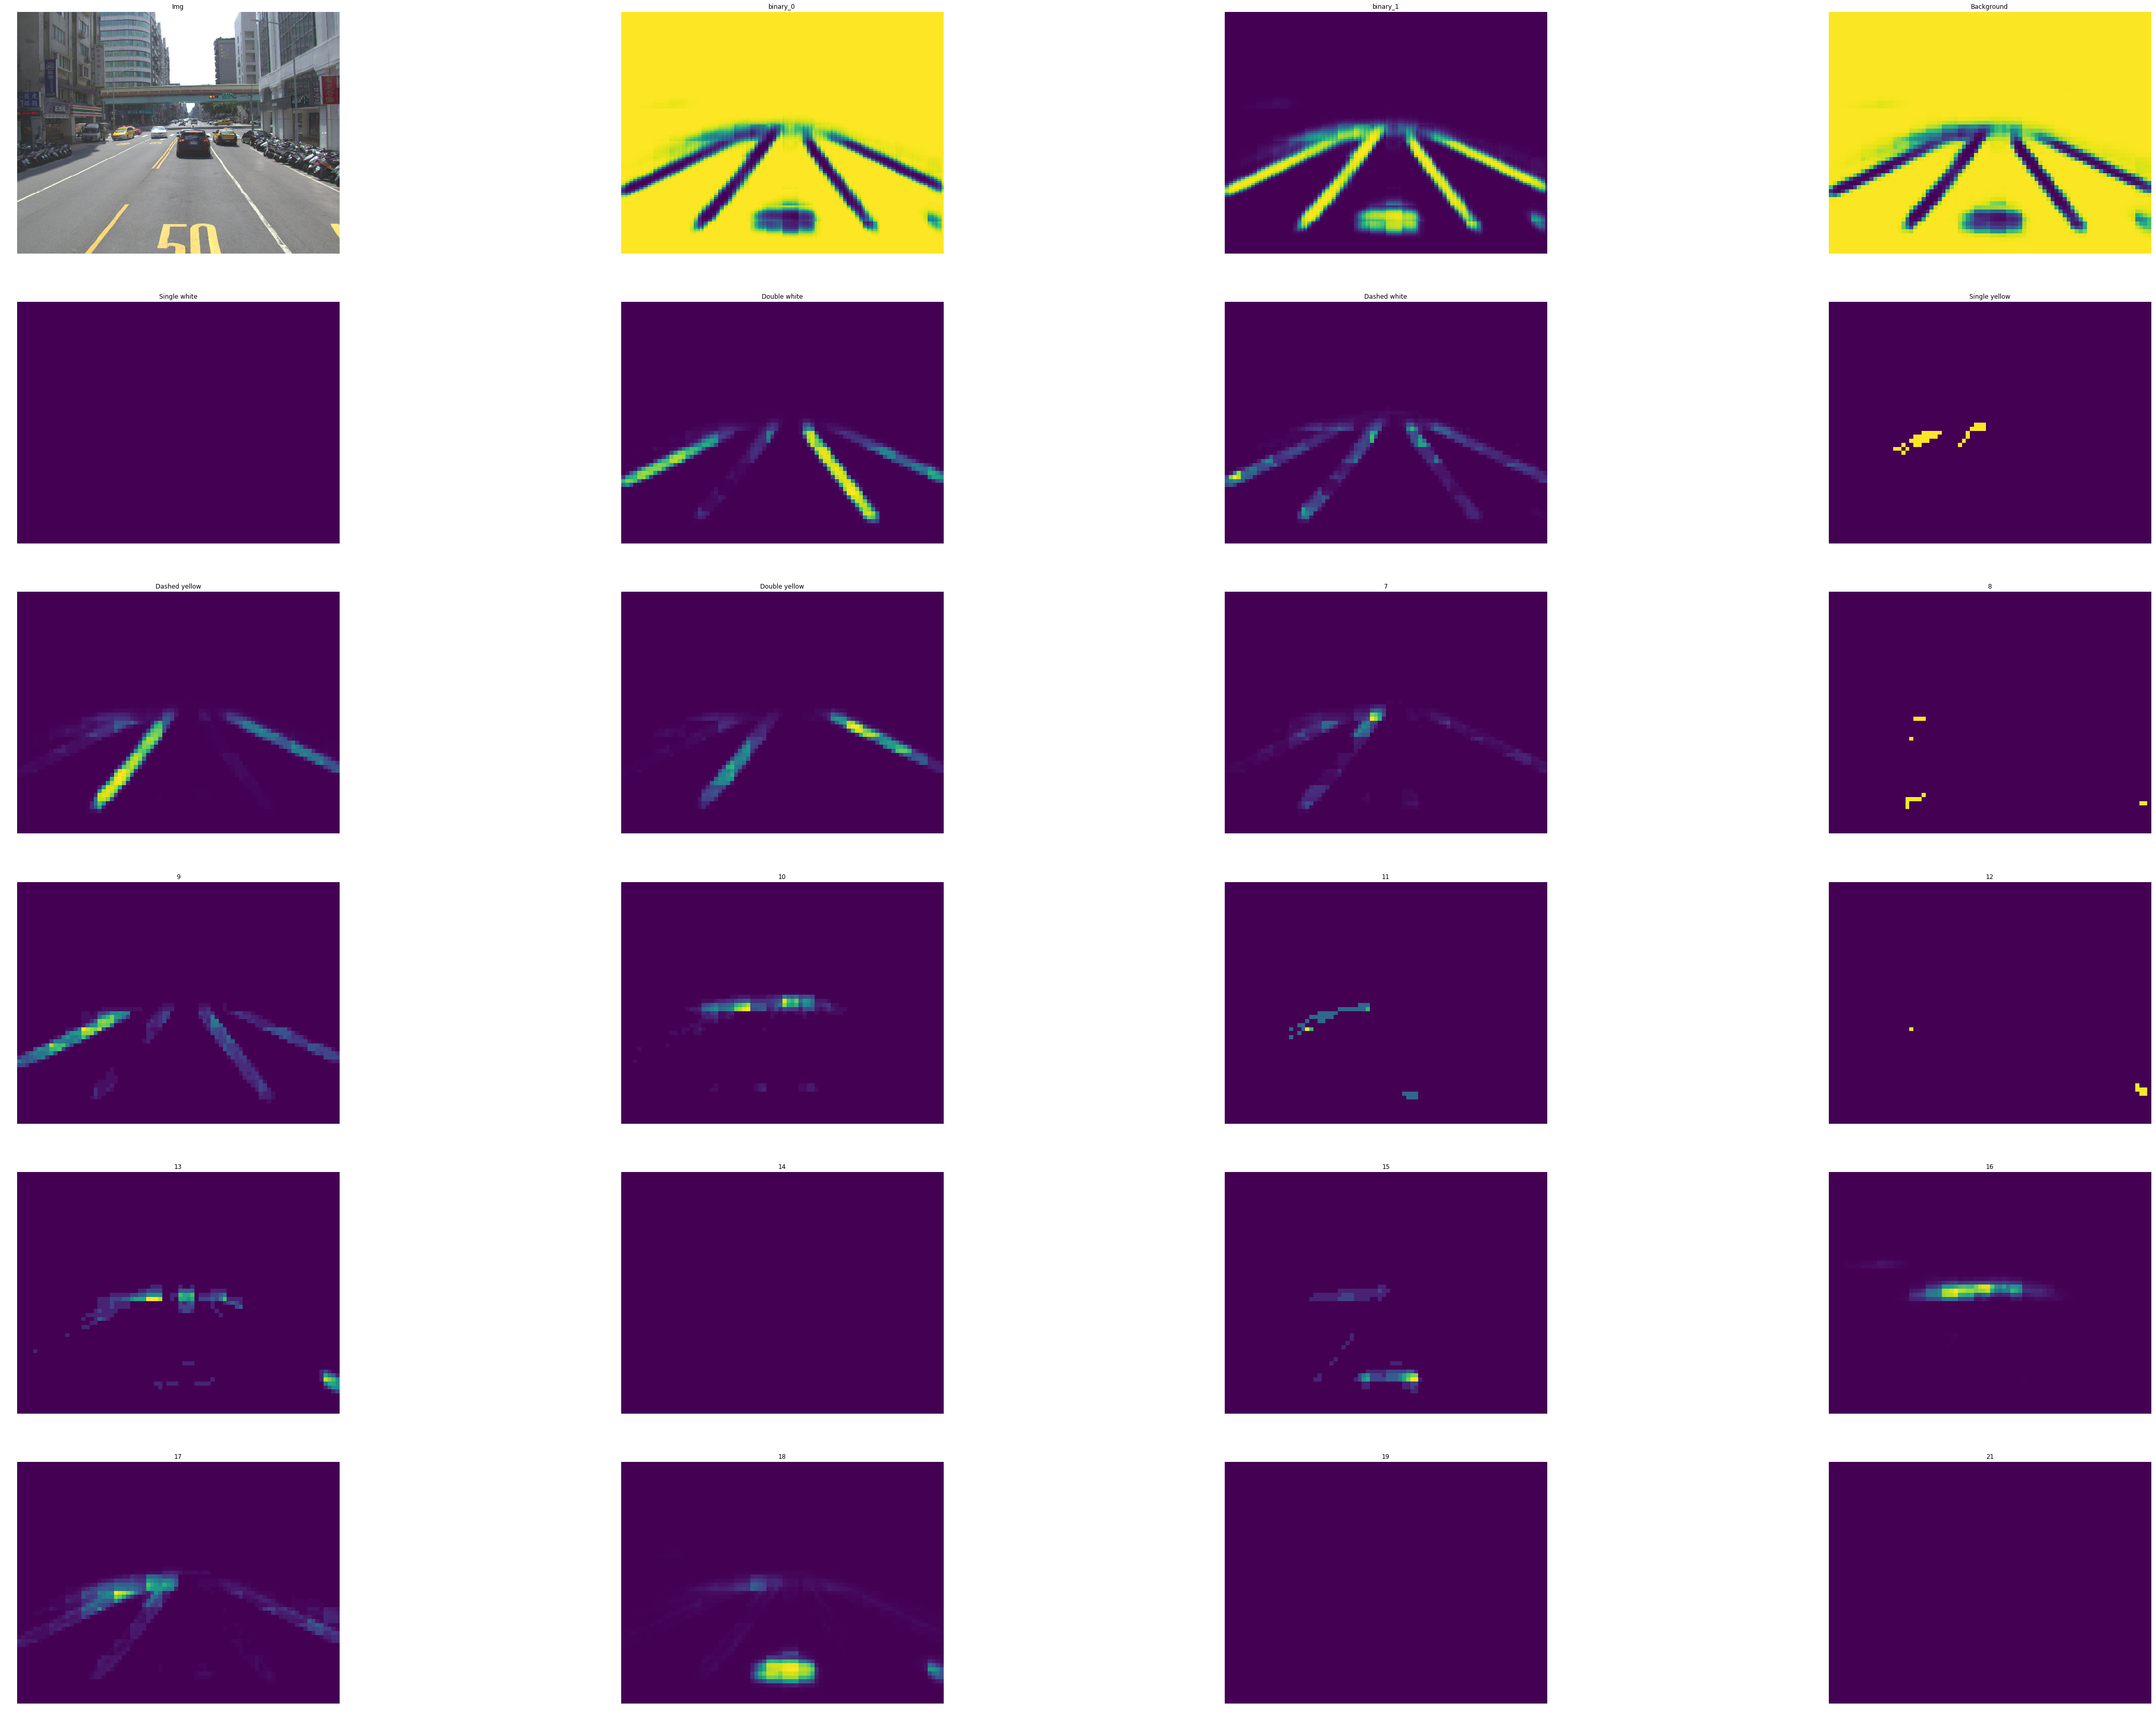

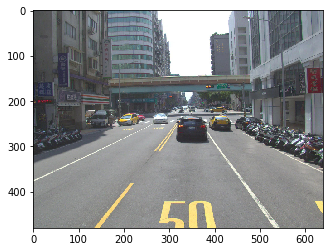

In [9]:
fig, axs = plt.subplots(nrows=6,ncols=4, figsize=(80, 60), facecolor='w', edgecolor='k')
axs = axs.ravel()

for filename in [0]:
    image = caffe.io.load_image(testimage, False)
    image = caffe.io.resize(image, (480, 640))
    axs[0].imshow(image, interpolation='nearest')
    axs[0].set_title('Img')
    axs[0].axis('off')

    binary_mask = net.blobs['binary-mask'].data[0]
    
    binary_heatmap_0 = (binary_mask[0]*100).astype(np.uint8)
    axs[1].imshow(binary_heatmap_0, interpolation='nearest')
    axs[1].set_title('binary_0')
    axs[1].axis('off')
    
    binary_heatmap_1 = (binary_mask[1]*100).astype(np.uint8)
    axs[2].imshow(binary_heatmap_1, interpolation='nearest')
    axs[2].set_title('binary_1')
    axs[2].axis('off') 
    
    predict_label = net.blobs['multi-label'].data[0]

    predict_label_argmax = np.argmax(predict_label, axis=0)
    problitity_heatmap = (predict_label_argmax*10).astype(np.uint8)
    bb = net.blobs['bb-output-tiled'].data[0]
     
    
    plt.figure()
    plt.imshow(image)
    scale = 255
    problitity_heatmap_0 = (predict_label[0]*scale).astype(np.uint8)
    axs[3].imshow(problitity_heatmap_0, interpolation='nearest')
    axs[3].set_title('Background')
    axs[3].axis('off')
    
    problitity_heatmap_1 = (predict_label[1]*scale).astype(np.uint8)
    axs[4].imshow(problitity_heatmap_1, interpolation='nearest')
    axs[4].set_title('Single white')
    axs[4].axis('off')
    
    problitity_heatmap_2 = (predict_label[2]*scale).astype(np.uint8)
    axs[5].imshow(problitity_heatmap_2, interpolation='nearest')
    axs[5].set_title('Double white')
    axs[5].axis('off')
    
    problitity_heatmap_3 = (predict_label[3]*scale).astype(np.uint8)                                                     
    axs[6].imshow(problitity_heatmap_3, interpolation='nearest')
    axs[6].set_title('Dashed white')
    axs[6].axis('off')
    
    problitity_heatmap_4 = (predict_label[4]*scale).astype(np.uint8)                                                       
    axs[7].imshow(problitity_heatmap_4, interpolation='nearest')
    axs[7].set_title('Single yellow')
    axs[7].axis('off')
    
    problitity_heatmap_5 = (predict_label[5]*scale).astype(np.uint8)
    axs[8].imshow(problitity_heatmap_5, interpolation='nearest')
    axs[8].set_title('Dashed yellow')
    axs[8].axis('off')
    
    problitity_heatmap_6 = (predict_label[6]*scale).astype(np.uint8)
    axs[9].imshow(problitity_heatmap_6, interpolation='nearest')
    axs[9].set_title('Double yellow')
    axs[9].axis('off')
    
    problitity_heatmap_7 = (predict_label[7]*scale).astype(np.uint8)
    axs[10].imshow(problitity_heatmap_7, interpolation='nearest')
    axs[10].set_title('7')
    axs[10].axis('off')
    
    problitity_heatmap_8 = (predict_label[8]*scale).astype(np.uint8)
    axs[11].imshow(problitity_heatmap_8, interpolation='nearest')
    axs[11].set_title('8')
    axs[11].axis('off')
    
    problitity_heatmap_9 = (predict_label[9]*scale).astype(np.uint8)
    axs[12].imshow(problitity_heatmap_9, interpolation='nearest')
    axs[12].set_title('9')
    axs[12].axis('off')
    
    problitity_heatmap_10 = (predict_label[10]*scale).astype(np.uint8)
    axs[13].imshow(problitity_heatmap_10, interpolation='nearest')
    axs[13].set_title('10')
    axs[13].axis('off')
    
    problitity_heatmap_11 = (predict_label[11]*scale).astype(np.uint8)
    axs[14].imshow(problitity_heatmap_11, interpolation='nearest')
    axs[14].set_title('11')
    axs[14].axis('off')
    
    problitity_heatmap_12 = (predict_label[12]*scale).astype(np.uint8)
    axs[15].imshow(problitity_heatmap_12, interpolation='nearest')
    axs[15].set_title('12')
    axs[15].axis('off')
    
    problitity_heatmap_13 = (predict_label[13]*scale).astype(np.uint8)
    axs[16].imshow(problitity_heatmap_13, interpolation='nearest')
    axs[16].set_title('13')
    axs[16].axis('off')
    
    problitity_heatmap_14 = (predict_label[14]*scale).astype(np.uint8)
    axs[17].imshow(problitity_heatmap_14, interpolation='nearest')
    axs[17].set_title('14')
    axs[17].axis('off')
    
    problitity_heatmap_15 = (predict_label[15]*scale).astype(np.uint8)
    axs[18].imshow(problitity_heatmap_15, interpolation='nearest')
    axs[18].set_title('15')
    axs[18].axis('off')
    
    problitity_heatmap_16 = (predict_label[16]*scale).astype(np.uint8)
    axs[19].imshow(problitity_heatmap_16, interpolation='nearest')
    axs[19].set_title('16')
    axs[19].axis('off')
    
    problitity_heatmap_17 = (predict_label[17]*scale).astype(np.uint8)
    axs[20].imshow(problitity_heatmap_17, interpolation='nearest')
    axs[20].set_title('17')
    axs[20].axis('off')
    
    problitity_heatmap_18 = (predict_label[18]*scale).astype(np.uint8)
    axs[21].imshow(problitity_heatmap_18, interpolation='nearest')
    axs[21].set_title('18')
    axs[21].axis('off')
    
    problitity_heatmap_19 = (predict_label[19]*scale).astype(np.uint8)
    axs[22].imshow(problitity_heatmap_19, interpolation='nearest')
    axs[22].set_title('19')
    axs[22].axis('off')
    
    problitity_heatmap_20 = (predict_label[20]*scale).astype(np.uint8)
    axs[23].imshow(problitity_heatmap_20, interpolation='nearest')
    axs[23].set_title('21')
    axs[23].axis('off')
    break

In [10]:
def _cluster_v2(data, eps=30, min_samples=20):
    """
    dbscan cluster
    :param prediction:
    :return:
    """
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    db_labels = db.labels_
    unique_labels = np.unique(db_labels)
    unique_labels = [tmp for tmp in unique_labels if tmp != -1]
    print('Cluster: {:d}'.format(len(unique_labels)))
    num_clusters = len(unique_labels)
    cluster_centers = db.components_
    indices = db.core_sample_indices_
    return num_clusters, db_labels, cluster_centers, indices

In [11]:
import math
def poly_line(data, num_clusters, db_labels, core_sample_indices_):
    core_samples_mask = np.zeros_like(db_labels, dtype=bool)
    core_samples_mask[core_sample_indices_] = True
    unique_labels = set(db_labels)
    cols = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    poly_line_list = []
    for k, col in zip(unique_labels, cols): 
        if k == -1: # Black used for noise. 
            col = [0, 0, 0, 1] 
        class_member_mask = (db_labels == k) 
        xy = data[class_member_mask & core_samples_mask]
        if len(xy[:, 0]) is 0 or len(xy[:, 1]) is 0:
            continue
        p = np.polyfit(xy[:, 0], xy[:, 1], 1)#(, , 3)
        poly_line = np.poly1d(p)
        poly_line_list.append([xy[:, 0], poly_line(xy[:, 0])])
    return poly_line_list

In [12]:
def generate_camera_conf_file(scale):
    """
    Generates camera.conf for IPM.cpp to use as parameters.
    All parameters are scalable to scale. The baseline picture size when scale=1 is 640*480
    However, if in IPM.cpp, parse_config(filename, ipmWidth, ipmHeight, cameraInfo, ipmInfo, UNITY) is used,
    then changing this function will not help change the parameters in IPM.cpp.
    """
    with open('camera.conf', 'w') as f:
        f.write('ipmWidth ' + str(int(2448 / scale)) + '\n') # output size!
        f.write('ipmHeight ' + str(int(2048 / scale)) + '\n')
        f.write('vpPortion 0.08\n') # how far is the image top from vanishing point (bc vp is too far, can't display all)
        f.write('ipmLeft 0\n') # 85 # pixel range on input to transfer
        f.write('ipmRight ' + str(int(2448 / scale) - 1) + '\n')
        f.write('ipmTop ' + str(int(830 / scale)) + '\n')
        f.write('ipmBottom ' + str(int(2048 / scale) - 1) + '\n')
        f.write('ipmInterpolation 0\n')
        f.write('focalLengthX %d\n'%(276 / scale)) #
        f.write('focalLengthY %d\n'%(276 / scale)) #
        f.write('opticalCenterX ' + str(int(1224 / scale) - 1) + '\n') #
        f.write('opticalCenterY ' + str(int(1024 / scale) - 1) + '\n') #
        f.write('cameraHeight 2180\n') # in mm
        f.write('pitch 13.0\n') #14 in degrees
        f.write('yaw  0.0\n')
        f.write('imageWidth ' + str(int(2448 / scale)) + '\n')
        f.write('imageHeight ' + str(int(2048 / scale)))


In [13]:
import IPM
def convert_gnd2ipm(img):
    scale = 3
    generate_camera_conf_file(scale)
    tmp = img
    tmp = cv2.resize(tmp, (2448/scale, 2048/scale))
    tmp = tmp.astype(dtype = np.float32, copy = False)
    ipm_img = np.zeros(tmp.shape[0:2], dtype = np.float32)
    ipm_gnd_converter = IPM.image_ipm(tmp, ipm_img)
    return ipm_gnd_converter, ipm_img

In [14]:
def convert_ipm2gnd(npx, npy, lines):
    IPM.points_ipm2image(npx, npy)
    tot = 0
    lines_in_gnd = []
    for i in range(len(lines)): # lines format: lines = [line1, line2, line3, ...], linei = [(x, y), (x, y), ...]
        lines_in_gnd.append([])
        for j in range(len(lines[i])):
            if (npy[tot] >= 0 and npy[tot] <= 2048/3 and npx[tot] >= 0 and npx[tot] <= 2448/3):
                lines_in_gnd[i].append((npx[tot], npy[tot]))
            tot += 1
    return lines_in_gnd, npx, npy

In [15]:
def poly_line2(poly_line_list , unique_labels):
    temp_poly_line_list = []
    img = cv2.imread(testimage)
    img = cv2.resize(img, (2448/3, 2048/3))
    plt.imshow(img[:,:,[2,1,0]])
    for group, col in zip(poly_line_list, range(len(unique_labels))):
        plt.plot(np.array(group)[: , 0], np.array(group)[:, 1], 'o', markerfacecolor=colors[col+1] ,markeredgecolor='k', markersize=14)
        p = np.polyfit(np.array(group)[:, 0], np.array(group)[:, 1], 2)
        poly_line = np.poly1d(p)
        temp_poly_line_list.append([np.array(group)[:, 0], poly_line(np.array(group)[:, 0])])
        plt.plot(np.array(group)[:, 0], poly_line(np.array(group)[:, 0]), '--', color=colors[col+1], linewidth=5)
    plt.title('Estimated number of clusters: %d' % len(unique_labels))
    plt.show()
    return temp_poly_line_list

In [16]:
binary_mask = extract_features(net,'binary-mask', channels=2,single_layer=1,factor=8)

In [17]:
ipm_gnd_converter, ipm_img = convert_gnd2ipm(binary_mask)

In [18]:
ipm_x,ipm_y,ipm_z = post_processing(ipm_img , 2, th=0.4)
ipm_data = np.c_[ipm_x,ipm_y]

/usr/lib/python2.7/dist-packages/scipy/signal/signaltools.py:351: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/lib/python2.7/dist-packages/scipy/signal/signaltools.py:352: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [19]:
ipm_num_clusters, ipm_db_labels, ipm_cluster_centers, ipm_core_sample_indices_ = _cluster_v2(ipm_data, eps=20, min_samples=10)

Cluster: 7


In [20]:
ipm_poly_line_list = poly_line(ipm_data, ipm_num_clusters, ipm_db_labels, ipm_core_sample_indices_)

In [21]:
temp_px = []
temp_py = []
temp_lines = []
for group in ipm_poly_line_list:
    temp_px.extend(group[0])
    temp_py.extend(group[1])
    line = []
    for i in range(len(group[0])):
        line.append([group[0][i], group[1][i]])
    temp_lines.append(line)
temp_px = np.array(temp_px, dtype='float32')
temp_py = np.array(temp_py, dtype='float32')

In [22]:
temp_cluster_list, temp_px_1, temp_py_1 = convert_ipm2gnd(temp_px, temp_py, temp_lines)

In [23]:
temp_data = np.c_[temp_px_1, temp_py_1]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


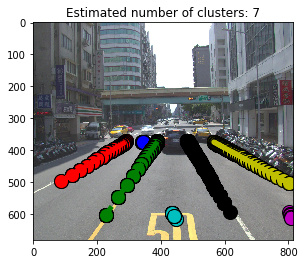

In [24]:
temp_poly_line_list = poly_line2(temp_cluster_list, set(ipm_db_labels))

In [25]:
gray_values = np.arange(256, dtype=np.uint8)
color_values = map(tuple, cv2.applyColorMap(gray_values, cv2.COLORMAP_JET).reshape(256, 3))
color_to_gray_map = dict(zip(color_values, gray_values))

In [26]:
width, height, nImages = (60, 80, 18)
images = np.zeros((width, height, nImages), np.uint8)
images[:, :, 0] = problitity_heatmap_1
images[:, :, 1] = problitity_heatmap_2
images[:, :, 2] = problitity_heatmap_3
images[:, :, 3] = problitity_heatmap_4
images[:, :, 4] = problitity_heatmap_5
images[:, :, 5] = problitity_heatmap_6
images[:, :, 6] = problitity_heatmap_7
images[:, :, 7] = problitity_heatmap_8
images[:, :, 8] = problitity_heatmap_9
images[:, :, 9] = problitity_heatmap_10
images[:, :, 10] = problitity_heatmap_11
images[:, :, 11] = problitity_heatmap_12
images[:, :, 12] = problitity_heatmap_13
images[:, :, 13] = problitity_heatmap_14
images[:, :, 14] = problitity_heatmap_15
images[:, :, 15] = problitity_heatmap_16
images[:, :, 16] = problitity_heatmap_17
images[:, :, 17] = problitity_heatmap_18
image = images.argmax(axis=2)

In [27]:
classes_prob = {}
for line, clo in zip(temp_poly_line_list, ['r', 'b', 'g', 'k', 'y', 'c', 'm', 'w']):
    line_classes = np.zeros((18), np.uint8)
    line_points = set()
    for point in np.c_[line[0],line[1]]:
        y = int(point[0]/2448*3*80)
        y = y if y < 80 else 79
        x = int(point[1]/2048*3*60)
        x = x if x < 60 else 59
        line_points.add((x, y))
    for point in line_points:
        class_index = image[point[0]][point[1]]
        line_classes[class_index] += 1
    print(line_classes)
    classes_prob[clo] = list(np.where(line_classes == np.amax(line_classes)))[0][0]
print('result:'+str(classes_prob))

[0 8 0 0 4 0 0 0 0 0 0 0 0 0 0 0 2 0]
[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 5 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 14  0  0  4  8  0  0  0  0  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
result:{'c': 17, 'b': 4, 'g': 4, 'k': 1, 'm': 17, 'r': 1, 'y': 1}
